In [1]:
!pip install numpy pandas statsmodels pyreadstat requests matplotlib seaborn
 

In [2]:

import statsmodels.api as sma
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import os
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot

In [3]:
os.makedirs("datasets", exist_ok=True)
if not os.path.isfile("datasets/serumchol.dta"):
    os.system("wget https://mollerfryd.dk/Reg/Data/serumchol.dta -P datasets")

In [4]:
serum = pd.read_stata("datasets/serumchol.dta")
serum

,sex,sbp,dbp,scl,bmi,id
0,Men,120.0,80.0,267.0,25.000000,2642.0
1,Men,130.0,78.0,192.0,28.400000,4627.0
2,Men,144.0,90.0,207.0,25.100000,2568.0
3,Men,92.0,66.0,231.0,26.200001,4192.0
4,Men,162.0,98.0,271.0,28.400000,3977.0
...,...,...,...,...,...,...
4694,Men,130.0,88.0,213.0,28.400000,3195.0
4695,Women,112.0,68.0,252.0,22.000000,1674.0
4696,Men,112.0,76.0,177.0,23.500000,4526.0
4697,Women,125.0,75.0,244.0,30.400000,4536.0


# 1

In [5]:
bins = [0, 10, 18.5, 25, 30, 60]
names = ['<10', '10-18.5', '18.5-25', "25-30", '30-60']

serum['bmi_who'] = pd.cut(serum['bmi'], bins, labels=names)
serum["bmi_cat"] = serum['bmi_who'].cat.codes
serum["sex_cat"] = serum["sex"].astype("category").cat.codes

<Axes: xlabel='bmi_who', ylabel='scl'>

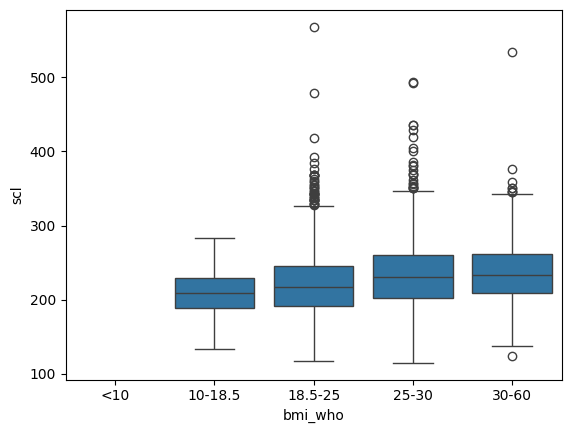

In [6]:
# Check if scl differs across bmi_cat
sns.boxplot(serum, x="bmi_who", y="scl")

In [7]:
# Looks like the value increases. No: it is not the same across groups.

# 2

In [8]:
# Lets fit a linear model to find the correlation.
y = serum["scl"]
X = serum[["sbp", "bmi_cat", "sex_cat"]]
model1 = smf.ols(formula="scl ~ sbp + C(bmi_who) + C(sex)", data=serum).fit()  # R interface - cooooool
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    scl   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     57.85
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           1.41e-58
Time:                        11:31:07   Log-Likelihood:                -24153.
No. Observations:                4658   AIC:                         4.832e+04
Df Residuals:                    4652   BIC:                         4.836e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               139.4493      3.305     42.189      0.000     132.969     145.929
C(bmi_who)[T.10-18.5]    22.3259      4.136      5.398      0.000      14.218      30.434
C(bmi_who)[T.18.5-25]    33.3361      1.473     22.631      0.000      30.448      36.224
C(bmi_who)[T.25-30]      42.6084      1.631     26.132      0.000      39.412      45.805
C(bmi_who)[T.30-60]      41.1789      2.152     19.137      0.000      36.960      45.398
C(sex)[T.Women]           3.0980      1.300      2.384      0.017       0.550       5.646
sbp                       0.3716      0.029     12.746      0.000       0.314       0.429
==============================================================================
Omnibus:                      660.251   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1570.022
Skew:                           0.814   Prob(JB):                         0.00
Kurtosis:                       5.332   Cond. No.                     1.04e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.81e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [9]:
# scl = C(bmi_who)[T.10-18.5] * 22.3259 +
#       C(bmi_who)[T.18.5-25] * 33.3361 + 
#       C(bmi_who)[T.25-30]	* 42.6084 + 
#       C(bmi_who)[T.30-60]	* 41.1789
#       C(sex)[T.Women] * 3.0980 +
#       sbp * 0.3688 +
#       139.4493

# 3

## Explaining coefficients
sbp: Estimated to 0.3716 [0.314; 0.429] CI.  0 not in CI, thus significant relation.

bmi30-: Estimated to 41.1789 [36.960; 45.398] CI. Compare to have a BMI> 10, scl is expected to be 41.1789 higher with BMI between 30 and 60

Women are expected to have a scl 3.0980 higher than men


## The relationship betwqeen scl ~sbp, woman, bmi=26 is:
 scl = 1 * 42.6084 + 
       1 * 3.0980 +
       sbp * 0.3688 +
       139.4493

## Make a plot of the relationship between the expected serum cholesterol and systolic blood pressure for the eight different combinations of sex and bmi_who.

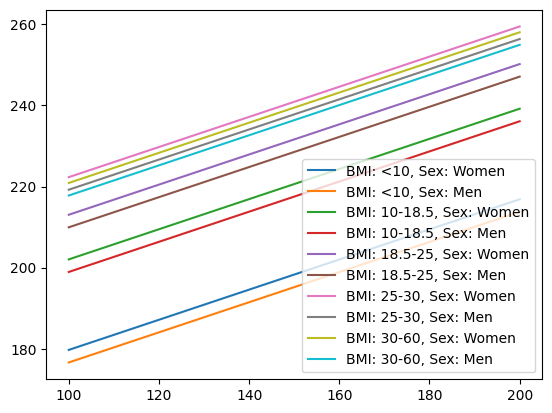

In [10]:
fig, ax = plt.subplots()

comb = []
for b in ['<10', '10-18.5', '18.5-25','25-30','30-60']:
    for s in ["Women", "Men"]:
        new_data = pd.DataFrame({"bmi_who": [b, b],
                                 "sex": [s, s],
                                 "sbp": [100, 200]})
        new_ = model1.predict(new_data)
        ax.plot([100, 200], [new_[0], new_[1]], label=f"BMI: {b}, Sex: {s}")
        ax.legend()


Write down the estimated relationship between serum cholesterol and BMI for a
man with a systolic blood pressure of 130 mmHg

 scl = C(bmi_who)[T.10-18.5] * 22.3259 +  
       C(bmi_who)[T.18.5-25] * 33.3361 +   
       C(bmi_who)[T.25-30]	* 42.6084 +   
       C(bmi_who)[T.30-60]	* 41.1789  
       130 * 0.3688 +  
       139.4493  

187.76066685177034
210.0865452418198
221.09675815661222
230.36903811775971
228.93959261754554


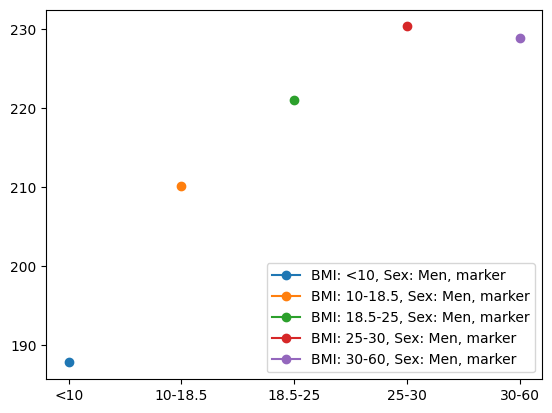

In [11]:
# Make a plot of the relationship between the expected serum cholesterol and BMI for a man with a systolic blood pressure of 130 mmHg.
fig, ax = plt.subplots()
bmis = ['<10', '10-18.5', '18.5-25','25-30','30-60']
new_data = pd.DataFrame({"bmi_who": bmis,
                            "sex": ["Men", "Men", "Men", "Men", "Men"],
                            "sbp": [130, 130, 130, 130, 130]})
new_ = model1.predict(new_data)
for i, n in enumerate(new_):
    print(n)
    ax.plot(bmis[i], n, label=f"BMI: {bmis[i]}, Sex: Men, marker", marker="o")
ax.legend()


# 4

In [12]:
# Find the expected scl, with 95% confidence interval, for a subject with sbp=85, sex=women and bmi_who=18.5-.
# Help here: https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels
new_data = pd.DataFrame({"bmi_who": bmis[0],
                         "sex": ["Women"],
                         "sbp": [85]})
res = model1.get_prediction(new_data)

In [13]:
print(res.predicted, res.conf_int())
res.summary_frame(alpha=0.05)

[174.13550506] [[171.32354255 176.94746758]]


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,174.135505,1.434328,171.323543,176.947468,89.294271,258.976739


# 5

In [14]:
serum["sbp2"] = np.sqrt(serum.sbp)


In [15]:
# Lets fit a linear model to find the correlation.
y = serum["scl"]
X = serum[["sbp", "sbp2", "bmi_cat", "sex_cat"]]
model2 = smf.ols(formula="scl ~ sbp + sbp2 + C(bmi_who) + C(sex)", data=serum).fit()  # R interface - cooooool
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    scl   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     54.16
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           7.22e-65
Time:                        11:31:08   Log-Likelihood:                -24137.
No. Observations:                4658   AIC:                         4.829e+04
Df Residuals:                    4651   BIC:                         4.833e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -152.5007     50.408     -3.025      0.002    -251.323     -53.678
C(bmi_who)[T.10-18.5]   -49.1581     12.987     -3.785      0.000     -74.619     -23.697
C(bmi_who)[T.18.5-25]   -39.5056     12.635     -3.127      0.002     -64.277     -14.734
C(bmi_who)[T.25-30]     -31.2132     12.822     -2.434      0.015     -56.350      -6.076
C(bmi_who)[T.30-60]     -32.6239     12.895     -2.530      0.011     -57.904      -7.344
C(sex)[T.Women]           3.8409      1.301      2.951      0.003       1.290       6.392
sbp                      -2.1784      0.440     -4.948      0.000      -3.042      -1.315
sbp2                     61.2575     10.554      5.804      0.000      40.567      81.948
==============================================================================
Omnibus:                      655.600   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1548.035
Skew:                           0.811   Prob(JB):                         0.00
Kurtosis:                       5.312   Cond. No.                     9.95e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.6e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

 sbp2 seems to correlate well with scl. In this case, BMI changes to be negatively correlate to scl. R², however, increases slightly. This model makes sense since we expect scl to flatten out at some point.
  

In [16]:
new_data = pd.DataFrame({"bmi_who": bmis[0],
                         "sex": ["Women"],
                         "sbp": [85],
                         "sbp2": [np.sqrt(85)]})
res = model2.get_prediction(new_data)
res.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,230.938867,9.890432,211.54893,250.328803,144.244419,317.633314


Now the mean is much higher than model1. 230.9 [211.6; 250.3].

# 6

In [17]:
# Lets fit a linear model to find the correlation.
y = serum["scl"]
X = serum[["sbp", "bmi", "sex_cat"]]
model3 = smf.ols(formula="scl ~ sbp + bmi + C(sex)", data=serum).fit()  # R interface - cooooool
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    scl   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     89.31
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           3.48e-56
Time:                        11:31:08   Log-Likelihood:                -24163.
No. Observations:                4658   AIC:                         4.833e+04
Df Residuals:                    4654   BIC:                         4.836e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         153.7528      4.848     31.718      0.000     144.249     163.256
C(sex)[T.Women]     2.1519      1.285      1.675      0.094      -0.367       4.670
sbp                 0.3687      0.030     12.490      0.000       0.311       0.427
bmi                 0.9511      0.165      5.754      0.000       0.627       1.275
==============================================================================
Omnibus:                      657.266   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1533.212
Skew:                           0.817   Prob(JB):                         0.00
Kurtosis:                       5.287   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

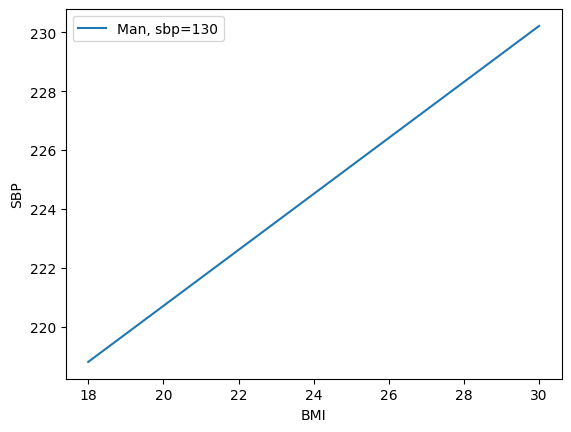

In [19]:
new_data = pd.DataFrame({"bmi": [18, 30],
                         "sex": ["Men", "Men"],
                         "sbp": [130, 130]})
res = model3.get_prediction(new_data)
res.summary_frame(alpha=0.05)
plt.plot([18,30], res.predicted, label="Man, sbp=130")
plt.xlabel(xlabel="BMI")
plt.ylabel(ylabel="SBP")
plt.legend()
plt.show()

# 7